In [24]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
X_train = pd.read_csv("../data/X_train.csv", index_col=[0], header=[0, 1, 2])
X_valid = pd.read_csv("../data/X_valid.csv", index_col=[0], header=[0, 1, 2])

In [4]:
X_train.head()

LEVEL2               alanine aminotransferase                                \
Aggregation Function                     mask                                 
hours_in                                    0    1    2    3    4    5    6   
3_145834_211552                           1.0  0.0  0.0  0.0  0.0  0.0  0.0   
6_107064_228232                           1.0  0.0  0.0  0.0  0.0  0.0  0.0   
9_150750_220597                           0.0  0.0  0.0  0.0  0.0  0.0  0.0   
11_194540_229441                          0.0  0.0  0.0  0.0  0.0  0.0  0.0   
12_112213_232669                          0.0  0.0  0.0  0.0  0.0  0.0  0.0   

LEVEL2                               ... white blood cell count urine         \
Aggregation Function                 ...          time_since_measured          
hours_in                7    8    9  ...                           14     15   
3_145834_211552       0.0  0.0  0.0  ...                          6.0    7.0   
6_107064_228232       0.0  0.0  0.0  ...                         30.0   31.0   
9_150750_220597       0.0  0.0  0.0  ...                         54.0   55.0   
11_194540_229441      0.0  0.0  0.0  ...                         78.0   79.0   
12_112213_232669      0.0  0.0  0.0  ...                        102.0  103.0   

LEVEL2                                                                        
Aggregation Function                                                          
hours_in                 16     17     18     19     20     21     22     23  
3_145834_211552         8.0    9.0   10.0   11.0   12.0   13.0   14.0   15.0  
6_107064_228232        32.0   33.0   34.0   35.0   36.0   37.0   38.0   39.0  
9_150750_220597        56.0   57.0   58.0   59.0   60.0   61.0   62.0   63.0  
11_194540_229441       80.0   81.0   82.0   83.0   84.0   85.0   86.0   87.0  
12_112213_232669      104.0  105.0  106.0  107.0  108.0  109.0  110.0  111.0  

[5 rows x 7488 columns]

A few descriptions:

mean: the actual value

hours_in: hours since the measurement was taken

mask: was the measurement taken this hour? (kind of a proxy to hours_in; can be used to count nulls)

In [10]:
# Check null count i.e. variables with no measurement in made in the day (= a row of mask all zeroes)
# In hindsight, this may not be such a good idea - the measurement may have been made on a prior day

nulls_data = pd.DataFrame()
for col in tqdm(X_train.columns.get_level_values('LEVEL2').unique()):
    nulls_data[col] = X_train.loc[:, (col, 'mask')].sum(axis=1).replace({0: np.nan})

 88%|██████████████████████████████████████████████████████████████████████▉          | 91/104 [00:00<00:00, 313.32it/s]/tmp/ipykernel_391/3377110865.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  nulls_data[col] = X_train.loc[:, (col, 'mask')].sum(axis=1).replace({0: np.nan})
100%|████████████████████████████████████████████████████████████████████████████████| 104/104 [00:00<00:00, 293.90it/s]


Text(0, 0.5, 'Number of variables')

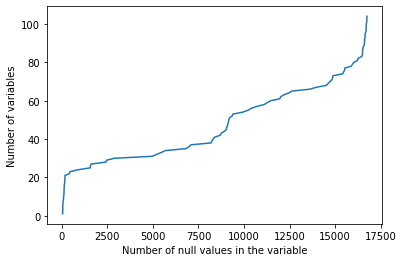

In [33]:
nulls_data.isna().sum().value_counts().sort_index().cumsum().plot()
ax = plt.gca()

ax.set_xlabel('Number of null values in the variable')
ax.set_ylabel('Number of variables')

The plot above shows that there are barely 20 or so columns (first spike) that have less than ~100 "null" values (as defined above). Even if you raised your tolerance for nulls to about 5000 (i.e. x-axis 5000), you get only about 10 more variables.

Let's just get all the variables which have less than 5000 nulls.

In [41]:
filtered_cols = nulls_data.columns[nulls_data.isna().sum() <= 5000]

In [42]:
filtered_cols

Index(['anion gap', 'bicarbonate', 'blood urea nitrogen', 'calcium',
       'chloride', 'creatinine', 'diastolic blood pressure', 'glucose',
       'heart rate', 'hematocrit', 'hemoglobin', 'magnesium',
       'mean blood pressure', 'mean corpuscular hemoglobin',
       'mean corpuscular hemoglobin concentration', 'mean corpuscular volume',
       'oxygen saturation', 'partial thromboplastin time', 'ph', 'phosphate',
       'phosphorous', 'platelets', 'potassium', 'prothrombin time inr',
       'prothrombin time pt', 'red blood cell count', 'respiratory rate',
       'sodium', 'systolic blood pressure', 'temperature',
       'white blood cell count'],
      dtype='object')

As I expected, it's more "regular measurement" type variables, like temperature, platelets, WBC count, BP, heart rate etc.

My intuition is that whenever any of these variables falls below or above a certain threshold, the patient is at a much higher risk of dying. So, let's get the min/max of each of these variables over the 24-hour period for each patient, and created a filtered dataset.

To deal with the nulls that get through anyway, we'll simply input the mean.

In [48]:
def filter_min_max(data):
    filtered_data = pd.DataFrame()
    for col in  filtered_cols:
        filtered_data[col+'_min'] = data.loc[:, (col, 'mask')].multiply(data.loc[:, (col, 'mean')]).replace({0: np.nan}).min(axis=1)
        filtered_data[col+'_max'] = data.loc[:, (col, 'mask')].multiply(data.loc[:, (col, 'mean')]).replace({0: np.nan}).max(axis=1)
    return filtered_data.copy()

In [49]:
X_train_filtered = filter_min_max(X_train)
X_valid_filtered = filter_min_max(X_valid)

In [50]:
X_train_filtered.shape, X_valid_filtered.shape

((16760, 62), (2394, 62))

In [51]:
X_train_filtered.head()

,anion gap_min,anion gap_max,bicarbonate_min,bicarbonate_max,blood urea nitrogen_min,blood urea nitrogen_max,calcium_min,calcium_max,chloride_min,chloride_max,...,respiratory rate_min,respiratory rate_max,sodium_min,sodium_max,systolic blood pressure_min,systolic blood pressure_max,temperature_min,temperature_max,white blood cell count_min,white blood cell count_max
3_145834_211552,0.152716,1.522228,-2.194973,-1.337656,0.741842,0.843772,-1.080013,-0.929001,0.599588,0.826316,...,-3.242477,-0.087956,-0.047833,0.814309,-1.791380,0.453183,-0.907598,0.754975,0.214086,1.105354
6_107064_228232,1.361109,2.086144,-1.766315,-1.123327,1.668479,1.807475,-0.256308,0.224186,-0.685206,-0.080597,...,-1.840468,0.262547,-0.786812,-0.047833,0.359660,2.604224,-1.079109,0.438275,-0.181589,-0.181589
9_150750_220597,-0.330641,-0.330641,0.591306,1.448622,-0.462786,-0.416455,0.636039,0.636039,-0.836358,-0.382902,...,-1.606799,-0.087956,-0.417323,0.321656,0.640230,3.247198,-1.738887,1.098053,-0.470685,0.107507
11_194540_229441,-0.088963,-0.088963,0.376977,0.591306,-0.555450,-0.323791,0.910607,0.910607,0.070555,0.070555,...,-0.788960,0.788300,0.506401,0.691146,-1.323763,-0.061196,-0.749278,0.504278,-0.302823,0.023576
12_112213_232669,-0.813998,3.294537,-2.837960,0.376977,0.093196,0.602846,0.018260,0.430112,0.826316,0.977468,...,-1.489965,-0.263207,0.136911,1.245380,-0.634027,2.136606,-1.738887,0.834166,-0.442708,-0.386754


In [ ]:
# 